# Importing the libraries

In [227]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn import preprocessing, model_selection
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LeakyReLU 
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Loading and Preprocessing the data

In [10]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [11]:
x_val, x_test, y_val, y_test = model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [29]:
winSize = (28,28)
blockSize = (28,28)
blockStride = (2,2)
cellSize = (4,4)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 0
nlevels = 64
signedGradients = True

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,
cellSize,nbins,derivAperture,
winSigma,histogramNormType,L2HysThreshold,
gammaCorrection,nlevels, signedGradients)


In [30]:
x_train_hog = np.array([hog.compute(x_train[0])])
x_test_hog = np.array([hog.compute(x_test[0])])
x_val_hog = np.array([hog.compute(x_val[0])])
for i in range(x_train.shape[0]-1):
    descriptor = hog.compute(x_train[i+1])
    x_train_hog = np.append(x_train_hog, np.array([descriptor]), axis=0)
for i in range(x_test.shape[0]-1):
    descriptor2 = hog.compute(x_test[i+1])
    x_test_hog = np.append(x_test_hog, np.array([descriptor2]), axis=0)
for i in range(x_val.shape[0]-1):
    descriptor3 = hog.compute(x_val[i+1])
    x_val_hog = np.append(x_val_hog, np.array([descriptor3]), axis=0)

sc = StandardScaler()
x_train_hog = sc.fit_transform(x_train_hog)
x_test_hog = sc.transform(x_test_hog)
x_val_hog = sc.transform(x_val_hog)

In [31]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Implementing the model and training it

In [228]:
model = tf.keras.models.Sequential()
model.add(Dense(units=32, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(LeakyReLU ())
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(LeakyReLU ())
model.add(Dense(10, activation='softmax'))

In [229]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [230]:
model.compile(SGD(learning_rate=lr_schedule, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [233]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 32)                14144     
                                                                 
 batch_normalization_30 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_44 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_31 (Bat  (None, 32)               128       
 chNormalization)                                    

In [232]:
history = model.fit(x_train_hog, y_train, batch_size = 64, epochs = 50, validation_data=(x_val_hog, y_val))

Epoch 1/50
938/938 [==============================] - 5s 4ms/step - loss: 0.9371 - accuracy: 0.7113 - val_loss: 0.5792 - val_accuracy: 0.8120
Epoch 2/50
938/938 [==============================] - 4s 4ms/step - loss: 0.5696 - accuracy: 0.8117 - val_loss: 0.4672 - val_accuracy: 0.8426
Epoch 3/50
938/938 [==============================] - 4s 4ms/step - loss: 0.4940 - accuracy: 0.8311 - val_loss: 0.4198 - val_accuracy: 0.8564
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 0.4539 - accuracy: 0.8454 - val_loss: 0.3927 - val_accuracy: 0.8656
Epoch 5/50
938/938 [==============================] - 4s 4ms/step - loss: 0.4252 - accuracy: 0.8544 - val_loss: 0.3750 - val_accuracy: 0.8680
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 0.4072 - accuracy: 0.8593 - val_loss: 0.3630 - val_accuracy: 0.8706
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 0.3920 - accuracy: 0.8641 - val_loss: 0.3537 - val_accuracy: 0.8750
Epoch 

# Evaluation

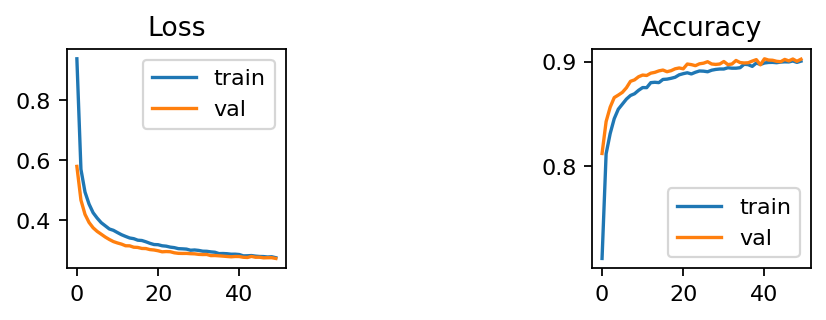

In [234]:
plt.figure(dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [235]:
y_hat = model.predict(x_test_hog)

157/157 [==============================] - 0s 2ms/step


In [236]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.9051496030938326
Accuracy:  0.8894
Precision:  0.9214670534604227
Recall:  0.8894
Confusion Matrix: 



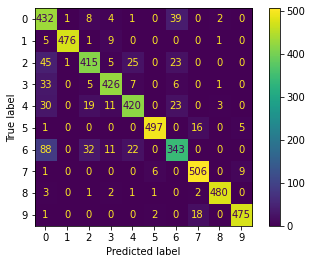

In [237]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()